In [ ]:
# ===============================
# 1. IMPORTS & SETUP
# ===============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128
BATCH_SIZE = 16

In [ ]:
# ===============================
# 2. LOAD & PREPROCESS DATA
# ===============================
# Set random seed for reproducibility
SEED = 42  # You can choose any integer value

# Load the dataset from Excel file
df = pd.read_excel('/content/dataset/Konkani_Dataset.xlsx')

# Display basic information about the dataset
print(f"Total samples in dataset: {len(df)}")
print(f"Column names: {df.columns.tolist()}")
print(f"Idiom distribution: {df['Idiom'].value_counts().to_dict()}")
print(f"Metaphor distribution: {df['Metaphor'].value_counts().to_dict()}")

# Prepare datasets based on the existing Split column for Idiom detection
idiom_train_df = df[df['Split'] == 'Train']
idiom_val_df = df[df['Split'] == 'Val']
idiom_test_df = df[df['Split'] == 'Test']

print("\n=== IDIOM DETECTION TASK (Using original split) ===")
print(f"Idiom training set size: {len(idiom_train_df)}")
print(f"Idiom validation set size: {len(idiom_val_df)}")
print(f"Idiom test set size: {len(idiom_test_df)}")
print(f"Idiom train/test ratio: {len(idiom_train_df)/(len(idiom_train_df)+len(idiom_test_df)):.2f}/{len(idiom_test_df)/(len(idiom_train_df)+len(idiom_test_df)):.2f}")

# Create a balanced dataset for metaphor detection (100 Yes, 100 No)
print("\n=== METAPHOR DETECTION TASK (Balanced subset) ===")
metaphor_yes = df[df['Metaphor'] == 'Yes'].head(100)
metaphor_no = df[df['Metaphor'] == 'No'].head(100)
metaphor_df = pd.concat([metaphor_yes, metaphor_no]).reset_index(drop=True)

# Create train-test split for metaphor detection (80% train, 20% test)
metaphor_train_df, metaphor_test_df = train_test_split(
    metaphor_df,
    test_size=0.2,
    random_state=SEED,
    stratify=metaphor_df['Metaphor']  # Ensure balanced split
)

print(f"Balanced metaphor dataset size: {len(metaphor_df)}")
print(f"Metaphor distribution: {metaphor_df['Metaphor'].value_counts().to_dict()}")
print(f"Metaphor training set size: {len(metaphor_train_df)}")
print(f"Metaphor test set size: {len(metaphor_test_df)}")


Total samples in dataset: 6520
Column names: ['Id', 'Expression', 'Contextual_Meaning', 'Sentence', 'Idiom', 'Metaphor', 'Split', 'Unnamed: 7', 'Unnamed: 8']
Idiom distribution: {'Yes': 4399, 'No': 2121}
Metaphor distribution: {'No': 383, 'Yes': 117}

=== IDIOM DETECTION TASK (Using original split) ===
Idiom training set size: 4990
Idiom validation set size: 0
Idiom test set size: 1530
Idiom train/test ratio: 0.77/0.23

=== METAPHOR DETECTION TASK (Balanced subset) ===
Balanced metaphor dataset size: 200
Metaphor distribution: {'Yes': 100, 'No': 100}
Metaphor training set size: 160
Metaphor test set size: 40


In [ ]:
# ===============================
# 3. TOKENIZER + DATASET
# ===============================
# Initialize the multilingual BERT tokenizer
'''
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
'''
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBERTv2-mlm-only")

# Define a dataset class that works for both idiom and metaphor classification
class TextClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, task_type="idiom", max_len=MAX_LEN):
        """
        Dataset class for text classification tasks

        Args:
            dataframe: Pandas DataFrame containing the data
            tokenizer: Tokenizer to use for encoding text
            task_type: Type of classification task ("idiom" or "metaphor")
            max_len: Maximum sequence length for tokenization
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.task_type = task_type
        self.max_len = max_len

        # Set the label column based on task type
        self.label_col = "Idiom" if task_type == "idiom" else "Metaphor"

        # Convert Yes/No labels to numeric values
        self.dataframe["label"] = self.dataframe[self.label_col].map({"Yes": 1, "No": 0})

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Format text based on task type
        if self.task_type == "idiom":
            text_to_encode = "[IDIOM]"+ str(row["Expression"]) + " [SEP] " + str(row["Sentence"])
        else:  # metaphor
            text_to_encode = str(row["Sentence"])

        # Tokenize the text
        encoding = self.tokenizer(
            text_to_encode,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(row["label"], dtype=torch.long)
        }

# ===============================
# IDIOM CLASSIFICATION SETUP
# ===============================
# Create validation set from training data if needed
if len(idiom_val_df) == 0:
    print("Creating validation set from training data...")
    # Get unique expressions to avoid data leakage
    unique_expressions = idiom_train_df["Expression"].unique()

    # Split expressions into train and val (no expression overlap)
    expr_train, expr_val = train_test_split(
        unique_expressions, test_size=0.2, random_state=42
    )

    # Assign expression-based split
    idiom_val_df = idiom_train_df[idiom_train_df["Expression"].isin(expr_val)].copy()
    idiom_train_df = idiom_train_df[idiom_train_df["Expression"].isin(expr_train)].copy()

print(f"Idiom - Train rows: {len(idiom_train_df)}, Val rows: {len(idiom_val_df)}, Test rows: {len(idiom_test_df)}")

# Create idiom datasets
idiom_train_ds = TextClassificationDataset(idiom_train_df, tokenizer, task_type="idiom")
idiom_val_ds = TextClassificationDataset(idiom_val_df, tokenizer, task_type="idiom")
idiom_test_ds = TextClassificationDataset(idiom_test_df, tokenizer, task_type="idiom")

# Create idiom dataloaders
idiom_train_loader = DataLoader(idiom_train_ds, batch_size=BATCH_SIZE, shuffle=True)
idiom_val_loader = DataLoader(idiom_val_ds, batch_size=BATCH_SIZE)
idiom_test_loader = DataLoader(idiom_test_ds, batch_size=BATCH_SIZE)

# ===============================
# METAPHOR CLASSIFICATION SETUP
# ===============================
print(f"Metaphor - Train rows: {len(metaphor_train_df)}, Test rows: {len(metaphor_test_df)}")

# Create metaphor datasets
metaphor_train_ds = TextClassificationDataset(metaphor_train_df, tokenizer, task_type="metaphor")
metaphor_test_ds = TextClassificationDataset(metaphor_test_df, tokenizer, task_type="metaphor")

# Create metaphor dataloaders
metaphor_train_loader = DataLoader(metaphor_train_ds, batch_size=BATCH_SIZE, shuffle=True)
metaphor_test_loader = DataLoader(metaphor_test_ds, batch_size=BATCH_SIZE)

print("Dataset and DataLoader setup complete!")


Creating validation set from training data...
Idiom - Train rows: 4029, Val rows: 961, Test rows: 1530
Metaphor - Train rows: 160, Test rows: 40
Dataset and DataLoader setup complete!


/tmp/ipython-input-7-4158217553.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["label"] = self.dataframe[self.label_col].map({"Yes": 1, "No": 0})


In [ ]:
# ===============================
# 4. MODEL: mBERT + BiLSTM
# ===============================
'''
class BERT_LSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=2):
        """
        BERT + BiLSTM model for text classification

        Args:
            hidden_dim: Hidden dimension of the LSTM
            num_classes: Number of output classes
        """
        super(BERT_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        pooled = torch.mean(lstm_out, dim=1)
        return self.fc(self.dropout(pooled))
'''

'''
class BERT_Only(nn.Module):
    def __init__(self, num_classes=2):
        super(BERT_Only, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output  # [CLS] token
        return self.fc(self.dropout(pooled))
'''

class IndicBERTv2_Only(nn.Module):
    def __init__(self, num_classes=2):
        super(IndicBERTv2_Only, self).__init__()
        self.bert = AutoModel.from_pretrained("ai4bharat/IndicBERTv2-mlm-only")
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # Use CLS token manually since pooler_output not present
        return self.fc(self.dropout(pooled))


# Create separate models for idiom and metaphor classification
print("Initializing models...")
idiom_model = IndicBERTv2_Only(num_classes=2).to(device)
metaphor_model = IndicBERTv2_Only(num_classes=2).to(device)

# Initialize optimizers and loss function
idiom_optimizer = torch.optim.AdamW(idiom_model.parameters(), lr=2e-5)
metaphor_optimizer = torch.optim.AdamW(metaphor_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print(f"Models initialized on device: {device}")
print("Idiom model and Metaphor model share the same architecture but will be trained separately")



Initializing models...


pytorch_model.bin:  36%|###5      | 619M/1.73G [00:00<?, ?B/s]

Models initialized on device: cuda
Idiom model and Metaphor model share the same architecture but will be trained separately


In [ ]:
# ===============================
# 5. TRAINING & VALIDATION
# ===============================
def train(model, loader, optimizer):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    """Validate the model on validation set"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, task_type="idiom"):
    """Evaluate the model and print classification report"""
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Set appropriate target names based on task type
    if task_type == "idiom":
        target_names = ["Non-Idiom", "Idiom"]
    else:  # metaphor
        target_names = ["Non-Metaphor", "Metaphor"]

    print(classification_report(
        targets, predictions,
        labels=[0, 1],
        target_names=target_names,
        zero_division=0
    ))

    return predictions, targets


In [ ]:
# ===============================
# 6. EARLY STOPPING TRAINING
# ===============================
def train_with_early_stopping(model, train_loader, val_loader, optimizer, task_name, epochs=20, patience=10):
    """Train model with early stopping"""
    print(f"\n=== Training {task_name} Model ===")
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        train_loss = train(model, train_loader, optimizer)
        val_loss = validate(model, val_loader)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("✅ Validation loss improved, saving model.")
        else:
            patience_counter += 1
            print("⚠️ No improvement.")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(best_model)
    print(f"\n=== {task_name} Model Training Complete ===")
    return model

# Train idiom model
EPOCHS = 20
PATIENCE = 10

# Check if validation set exists for idiom task
if len(idiom_val_df) > 0:
    idiom_model = train_with_early_stopping(
        idiom_model, idiom_train_loader, idiom_val_loader,
        idiom_optimizer, "Idiom", EPOCHS, PATIENCE
    )
    print("\n=== Idiom Model Validation Results ===")
    evaluate(idiom_model, idiom_val_loader, task_type="idiom")
else:
    print("No validation set available for idiom task. Skipping training.")

# Train metaphor model
# Create validation set for metaphor if needed
metaphor_val_df = metaphor_test_df  # Using test set as validation for simplicity
metaphor_val_ds = TextClassificationDataset(metaphor_val_df, tokenizer, task_type="metaphor")
metaphor_val_loader = DataLoader(metaphor_val_ds, batch_size=BATCH_SIZE)

metaphor_model = train_with_early_stopping(
    metaphor_model, metaphor_train_loader, metaphor_val_loader,
    metaphor_optimizer, "Metaphor", EPOCHS, PATIENCE
)
print("\n=== Metaphor Model Validation Results ===")
evaluate(metaphor_model, metaphor_val_loader, task_type="metaphor")



=== Training Idiom Model ===

Epoch 1


Training: 100%|██████████| 252/252 [01:39<00:00,  2.53it/s]


Train Loss: 0.5219 | Val Loss: 0.4027
✅ Validation loss improved, saving model.

Epoch 2


Training: 100%|██████████| 252/252 [01:42<00:00,  2.45it/s]


Train Loss: 0.3444 | Val Loss: 0.3727
✅ Validation loss improved, saving model.

Epoch 3


Training: 100%|██████████| 252/252 [01:43<00:00,  2.44it/s]


Train Loss: 0.2389 | Val Loss: 0.4165
⚠️ No improvement.

Epoch 4


Training: 100%|██████████| 252/252 [01:43<00:00,  2.43it/s]


Train Loss: 0.1478 | Val Loss: 0.5091
⚠️ No improvement.

Epoch 5


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.1066 | Val Loss: 0.4451
⚠️ No improvement.

Epoch 6


Training: 100%|██████████| 252/252 [01:43<00:00,  2.42it/s]


Train Loss: 0.0654 | Val Loss: 0.5655
⚠️ No improvement.

Epoch 7


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.0371 | Val Loss: 0.6296
⚠️ No improvement.

Epoch 8


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.0412 | Val Loss: 0.8043
⚠️ No improvement.

Epoch 9


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.0272 | Val Loss: 0.7989
⚠️ No improvement.

Epoch 10


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.0391 | Val Loss: 0.6003
⚠️ No improvement.

Epoch 11


Training: 100%|██████████| 252/252 [01:43<00:00,  2.42it/s]


Train Loss: 0.0238 | Val Loss: 0.8241
⚠️ No improvement.

Epoch 12


Training: 100%|██████████| 252/252 [01:44<00:00,  2.42it/s]


Train Loss: 0.0274 | Val Loss: 0.7958
⚠️ No improvement.
⏹️ Early stopping triggered.

=== Idiom Model Training Complete ===

=== Idiom Model Validation Results ===
              precision    recall  f1-score   support

   Non-Idiom       0.77      0.67      0.72       295
       Idiom       0.86      0.91      0.89       666

    accuracy                           0.84       961
   macro avg       0.82      0.79      0.80       961
weighted avg       0.84      0.84      0.84       961


=== Training Metaphor Model ===

Epoch 1


Training: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Train Loss: 0.6953 | Val Loss: 0.6775
✅ Validation loss improved, saving model.

Epoch 2


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.6978 | Val Loss: 0.6746
✅ Validation loss improved, saving model.

Epoch 3


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.6829 | Val Loss: 0.6786
⚠️ No improvement.

Epoch 4


Training: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Train Loss: 0.6810 | Val Loss: 0.6794
⚠️ No improvement.

Epoch 5


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.6554 | Val Loss: 0.6574
✅ Validation loss improved, saving model.

Epoch 6


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.5981 | Val Loss: 0.6183
✅ Validation loss improved, saving model.

Epoch 7


Training: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Train Loss: 0.5616 | Val Loss: 0.5376
✅ Validation loss improved, saving model.

Epoch 8


Training: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Train Loss: 0.3120 | Val Loss: 0.4650
✅ Validation loss improved, saving model.

Epoch 9


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.1538 | Val Loss: 0.3834
✅ Validation loss improved, saving model.

Epoch 10


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0813 | Val Loss: 0.4252
⚠️ No improvement.

Epoch 11


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0298 | Val Loss: 0.2785
✅ Validation loss improved, saving model.

Epoch 12


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0121 | Val Loss: 0.2626
✅ Validation loss improved, saving model.

Epoch 13


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0087 | Val Loss: 0.3517
⚠️ No improvement.

Epoch 14


Training: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Train Loss: 0.0041 | Val Loss: 0.3653
⚠️ No improvement.

Epoch 15


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.0023 | Val Loss: 0.3602
⚠️ No improvement.

Epoch 16


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0053 | Val Loss: 0.5114
⚠️ No improvement.

Epoch 17


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.0037 | Val Loss: 0.6197
⚠️ No improvement.

Epoch 18


Training: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.0193 | Val Loss: 0.6336
⚠️ No improvement.

Epoch 19


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0328 | Val Loss: 0.5667
⚠️ No improvement.

Epoch 20


Training: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Train Loss: 0.0326 | Val Loss: 0.5487
⚠️ No improvement.

=== Metaphor Model Training Complete ===

=== Metaphor Model Validation Results ===
              precision    recall  f1-score   support

Non-Metaphor       0.94      0.85      0.89        20
    Metaphor       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



([np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0)],
 [np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int6

In [ ]:
# ===============================
# 7. ATTENTION HEAD IMPORTANCE ANALYSIS
# ===============================
def analyze_attention_importance(model, val_loader, model_name="Model"):
    """
    Analyze and visualize attention head importance for a given model

    Args:
        model: The model to analyze
        val_loader: Validation data loader
        model_name: Name of the model for display purposes
    """
    head_grads = {}

    def save_attention_hook(layer_id, head_id):
        def hook_fn(grad):
            key = (layer_id, head_id)
            grad_norm = grad.detach().pow(2).sum().item()
            head_grads[key] = head_grads.get(key, 0) + grad_norm
        return hook_fn

    def register_attention_hooks(model):
        hooks = []
        for layer_id, layer in enumerate(model.bert.encoder.layer):
            def backward_hook_fn(module, grad_input, grad_output, lid=layer_id):
                batch_size, seq_len, hidden = grad_output[0].shape
                head_dim = hidden // layer.attention.self.num_attention_heads
                reshaped = grad_output[0].view(batch_size, seq_len, -1, head_dim).mean(1)
                for head_id in range(reshaped.shape[1]):
                    g = reshaped[:, head_id, :].reshape(-1)
                    save_attention_hook(lid, head_id)(g)
            hooks.append(layer.output.register_full_backward_hook(backward_hook_fn))
        return hooks

    print(f"\n=== Analyzing Attention Head Importance for {model_name} ===")

    # Register hooks and compute gradients
    model.train()  # required for cuDNN + LSTM backprop
    hooks = register_attention_hooks(model)

    with torch.set_grad_enabled(True):  # Ensures autograd is fully on
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            model.zero_grad()
            loss.backward()
            break  # only one batch needed

    # Remove hooks
    for h in hooks:
        h.remove()

    model.eval()

    # Normalize gradients and organize by layer
    layer_head_importance = {}
    for (layer, head), grad_val in head_grads.items():
        layer_head_importance.setdefault(layer, []).append(grad_val)

    # Print normalized importance scores
    print(f"\n{model_name} Attention Head Importance (normalized):")
    for layer in sorted(layer_head_importance):
        scores = np.array(layer_head_importance[layer])
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        print(f"Layer {layer}: {np.round(norm_scores, 3).tolist()}")

    # Visualize as heatmap
    num_layers = max(layer_head_importance.keys()) + 1
    num_heads = max(len(v) for v in layer_head_importance.values())
    importance_matrix = np.zeros((num_layers, num_heads))

    for layer, scores in layer_head_importance.items():
        scores = np.array(scores)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)  # normalize again
        importance_matrix[layer, :len(scores)] = scores

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        importance_matrix,
        annot=True,
        cmap="YlGnBu",
        xticklabels=[f"H{i}" for i in range(num_heads)],
        yticklabels=[f"L{i}" for i in range(num_layers)],
        cbar_kws={'label': 'Normalized Importance'}
    )
    plt.title(f"Attention Head Importance Heatmap (Layer vs. Head)")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_attention_importance.png")
    plt.show()

    return layer_head_importance



=== IDIOM MODEL ANALYSIS ===

=== Analyzing Attention Head Importance for Idiom ===

Idiom Attention Head Importance (normalized):
Layer 0: [0.088, 0.413, 0.13, 0.218, 0.027, 0.359, 0.354, 0.396, 0.0, 1.0, 0.727, 0.354]
Layer 1: [0.263, 1.0, 0.547, 0.268, 0.396, 0.548, 0.0, 0.757, 0.674, 0.579, 0.491, 0.753]
Layer 2: [0.427, 0.439, 0.97, 0.55, 0.0, 0.691, 0.011, 0.616, 0.02, 0.468, 1.0, 0.26]
Layer 3: [0.273, 0.106, 1.0, 0.886, 0.373, 0.723, 0.512, 0.29, 0.307, 0.196, 0.616, 0.0]
Layer 4: [0.173, 0.892, 0.918, 0.907, 0.805, 0.434, 0.395, 0.11, 0.0, 0.849, 1.0, 0.111]
Layer 5: [0.515, 0.0, 0.706, 1.0, 0.43, 0.512, 0.177, 0.475, 0.445, 0.689, 0.729, 0.048]
Layer 6: [0.249, 0.094, 0.451, 0.999, 0.318, 0.353, 0.185, 0.059, 0.348, 0.587, 0.508, 0.0]
Layer 7: [0.351, 0.369, 0.693, 0.998, 0.344, 0.0, 0.628, 0.342, 0.272, 0.739, 0.642, 0.629]
Layer 8: [0.057, 0.595, 0.0, 0.634, 0.82, 0.843, 0.997, 0.24, 0.968, 0.409, 0.192, 0.564]
Layer 9: [0.329, 0.201, 0.0, 0.996, 0.301, 0.344, 0.654, 0.196

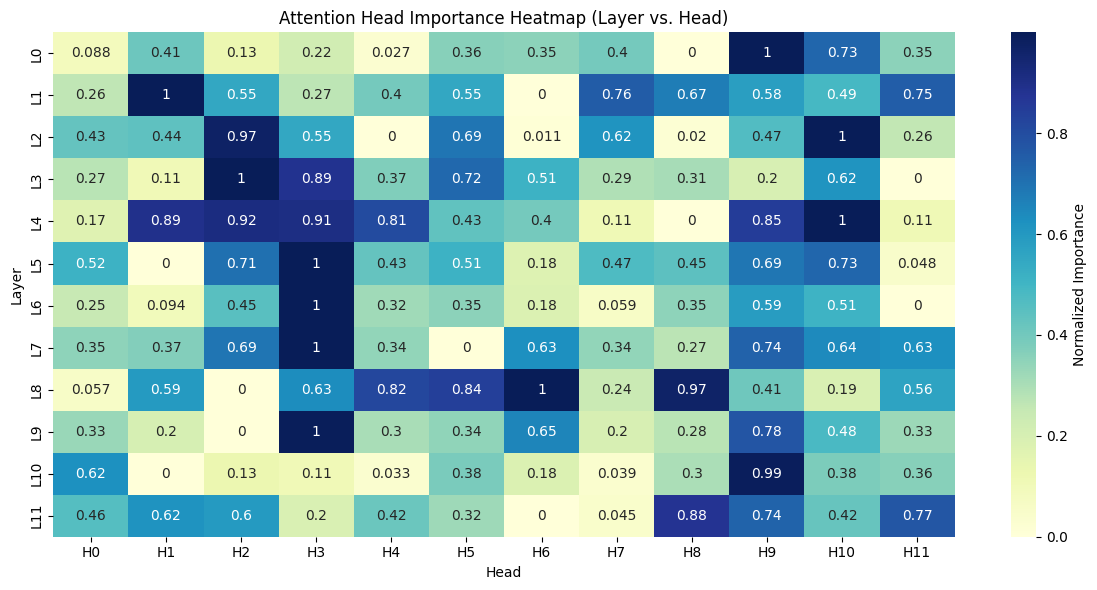


=== METAPHOR MODEL ANALYSIS ===

=== Analyzing Attention Head Importance for Metaphor ===

Metaphor Attention Head Importance (normalized):
Layer 0: [0.499, 1.0, 0.373, 0.307, 0.007, 0.0, 0.3, 0.842, 0.095, 0.673, 0.392, 0.348]
Layer 1: [1.0, 0.0, 0.42, 0.074, 0.254, 0.504, 0.337, 0.66, 0.007, 0.436, 0.414, 0.116]
Layer 2: [0.437, 0.557, 0.742, 0.426, 0.473, 0.478, 0.0, 1.0, 0.865, 0.627, 0.278, 0.211]
Layer 3: [0.771, 0.391, 1.0, 0.323, 0.173, 0.146, 0.755, 0.545, 0.0, 0.504, 0.844, 0.416]
Layer 4: [0.122, 0.412, 0.318, 0.71, 0.526, 0.151, 0.395, 0.425, 0.838, 0.17, 1.0, 0.0]
Layer 5: [0.752, 0.996, 0.315, 1.0, 0.596, 0.47, 0.313, 0.984, 0.884, 0.733, 0.548, 0.0]
Layer 6: [0.15, 0.0, 0.406, 0.873, 1.0, 0.984, 0.076, 0.431, 0.055, 0.563, 0.813, 0.155]
Layer 7: [0.357, 0.564, 0.234, 0.706, 1.0, 0.439, 0.0, 0.454, 0.842, 0.671, 0.433, 0.47]
Layer 8: [0.543, 0.368, 0.538, 0.473, 1.0, 0.623, 0.203, 0.764, 0.939, 0.636, 0.0, 0.868]
Layer 9: [0.822, 0.784, 0.645, 1.0, 0.17, 0.0, 0.299, 0.46

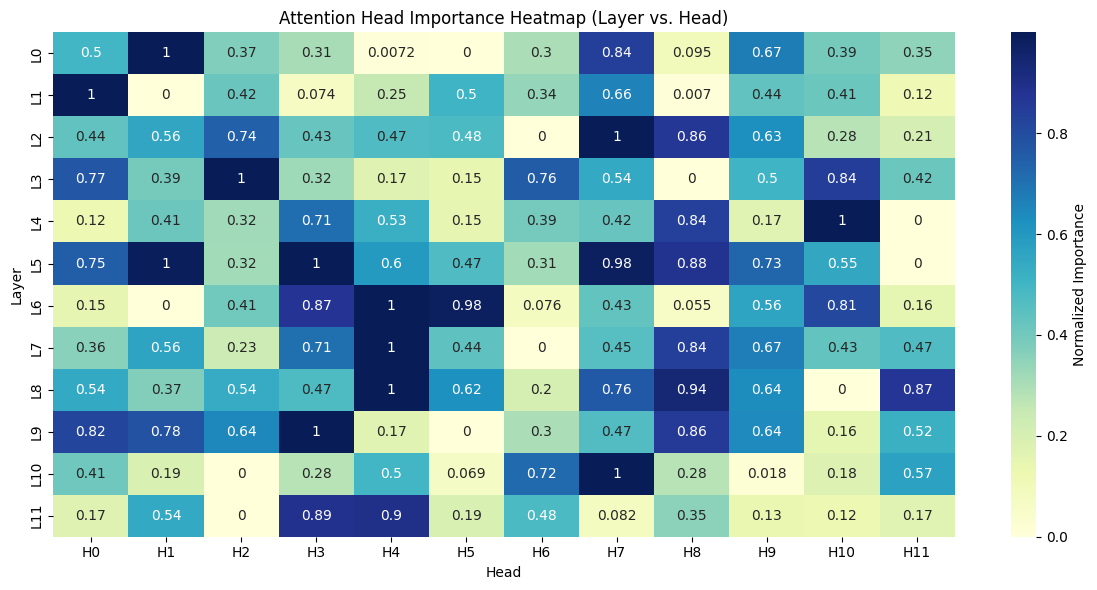

In [ ]:
# ===============================
# 8. ANALYZE MODELS SEPARATELY
# ===============================
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def flatten_and_normalize(layer_head_importance):
    flat = {}
    for layer, scores in layer_head_importance.items():
        scores = np.array(scores)
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        for head, score in enumerate(norm_scores):
            flat[(layer, head)] = float(score)
    return flat



# Analyze attention head importance for idiom model
print("\n=== IDIOM MODEL ANALYSIS ===")
idiom_importance_nested = analyze_attention_importance(idiom_model, idiom_val_loader, "Idiom")
idiom_importance = flatten_and_normalize(idiom_importance_nested)



# Analyze attention head importance for metaphor model
print("\n=== METAPHOR MODEL ANALYSIS ===")
metaphor_importance_nested = analyze_attention_importance(metaphor_model, metaphor_val_loader, "Metaphor")
metaphor_importance = flatten_and_normalize(metaphor_importance_nested)


In [ ]:
print(idiom_importance)

{(11, 0): 0.4582322429222036, (11, 1): 0.6195224070962695, (11, 2): 0.5973962139815633, (11, 3): 0.1952091281745492, (11, 4): 0.4176864642405202, (11, 5): 0.3217510059145549, (11, 6): 0.0, (11, 7): 0.045079551777596295, (11, 8): 0.8785781468521913, (11, 9): 0.7381946727916759, (11, 10): 0.42475479336165056, (11, 11): 0.7715314934246108, (10, 0): 0.6231703549207814, (10, 1): 0.0, (10, 2): 0.12908794532131698, (10, 3): 0.1079233280259109, (10, 4): 0.03349701396442485, (10, 5): 0.38378812611561125, (10, 6): 0.18363517446895022, (10, 7): 0.03852557202083913, (10, 8): 0.2975816415544144, (10, 9): 0.9893724977338315, (10, 10): 0.38148558538615146, (10, 11): 0.36158097709677206, (9, 0): 0.32943098321798914, (9, 1): 0.2007019084665673, (9, 2): 0.0, (9, 3): 0.9955591348738997, (9, 4): 0.301432144719443, (9, 5): 0.34408540547580563, (9, 6): 0.6535696885386418, (9, 7): 0.1959611987641119, (9, 8): 0.2771474932393782, (9, 9): 0.7771675382569534, (9, 10): 0.4819393366686283, (9, 11): 0.3254918775442

In [ ]:
# ===============================
# 9. ATTENTION HEAD PRUNING & EVALUATION (BERT-Only Version)
# ===============================

def create_importance_matrix(layer_head_importance, num_layers=12, num_heads=12):
    matrix = []
    for layer in range(num_layers):
        heads = []
        for head in range(num_heads):
            value = layer_head_importance.get((layer, head), 0.0)
            heads.append(value)
        matrix.append(heads)
    return matrix

def prune_and_evaluate_model(model, layer_head_importance, test_loader, model_name="Model", threshold=0.0001):
    print(f"\nRaw (layer, head) importance scores:")
    # for (layer, head), score in sorted(layer_head_importance.items()):
    #     print(f"  Layer {layer:02d}, Head {head:02d} = {score}")
    # Build importance matrix from dictionary
    importance_matrix = create_importance_matrix(layer_head_importance)
    importance_matrix_tensor = torch.tensor(importance_matrix, dtype=torch.float32)

    # Count heads below threshold
    print(f"\nNumber of heads below threshold: {(importance_matrix_tensor < threshold).sum().item()}")

    # Initialize head mask
    head_mask = torch.zeros_like(importance_matrix_tensor)

    for layer in range(importance_matrix_tensor.shape[0]):
        layer_importance = importance_matrix_tensor[layer]
        mask = (layer_importance > threshold).float()

        # Ensure at least one head is kept per layer
        if mask.sum() == 0:
            max_head = torch.argmax(layer_importance)
            mask[max_head] = 1.0

        head_mask[layer] = mask

    head_mask = head_mask.to(device)

    # Count pruning stats
    pruned_heads_count = torch.sum(head_mask == 0.0).item()
    total_heads = head_mask.numel()
    pruning_percentage = (pruned_heads_count / total_heads) * 100

    print(f"{model_name} Pruning: {pruned_heads_count} of {total_heads} heads pruned ({pruning_percentage:.2f}%)")

    # Evaluate original and pruned models
    print(f"\n{model_name} Original Model (No Pruning)")
    evaluate(model, test_loader, task_type=model_name.lower())

    print(f"\n{model_name} Pruned Model (Threshold-Based Pruning @ {threshold})")
    pruned_model = PrunedBERT_Only(head_mask=head_mask, num_classes=2).to(device)
    evaluate(pruned_model, test_loader, task_type=model_name.lower())

    return pruned_model, pruning_percentage

from transformers import AutoModel

class PrunedBERT_Only(nn.Module):
    def __init__(self, head_mask, num_classes=2, model_name="ai4bharat/indic-bert-v2"):
        super().__init__()
        self.bert = AutoModel.from_pretrained("ai4bharat/IndicBERTv2-mlm-only")
        self.head_mask = head_mask
        self.hidden_size = self.bert.config.hidden_size  # usually 768, but may differ
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=self.head_mask
        )
        pooled = outputs.pooler_output  # or use outputs.last_hidden_state[:, 0] if needed
        return self.fc(self.dropout(pooled))



# Prune and evaluate idiom model
print("\n=== IDIOM MODEL PRUNING ===")
idiom_pruned_model, idiom_pruning_percentage = prune_and_evaluate_model(
    idiom_model,
    idiom_importance,
    idiom_test_loader,
    "Idiom"
)

# Prune and evaluate metaphor model
print("\n=== METAPHOR MODEL PRUNING ===")
metaphor_pruned_model, metaphor_pruning_percentage = prune_and_evaluate_model(
    metaphor_model,
    metaphor_importance,
    metaphor_test_loader,
    "Metaphor"
)

# Print summary
print("\n=== PRUNING SUMMARY ===")
print(f"Idiom model: {idiom_pruning_percentage:.2f}% of attention heads pruned")
print(f"Metaphor model: {metaphor_pruning_percentage:.2f}% of attention heads pruned")




=== IDIOM MODEL PRUNING ===

Raw (layer, head) importance scores:

Number of heads below threshold: 12
Idiom Pruning: 12 of 144 heads pruned (8.33%)

Idiom Original Model (No Pruning)
              precision    recall  f1-score   support

   Non-Idiom       0.76      0.80      0.78       434
       Idiom       0.92      0.90      0.91      1096

    accuracy                           0.87      1530
   macro avg       0.84      0.85      0.84      1530
weighted avg       0.87      0.87      0.87      1530


Idiom Pruned Model (Threshold-Based Pruning @ 0.0001)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


              precision    recall  f1-score   support

   Non-Idiom       0.00      0.00      0.00       434
       Idiom       0.72      1.00      0.83      1096

    accuracy                           0.72      1530
   macro avg       0.36      0.50      0.42      1530
weighted avg       0.51      0.72      0.60      1530


=== METAPHOR MODEL PRUNING ===

Raw (layer, head) importance scores:

Number of heads below threshold: 12
Metaphor Pruning: 12 of 144 heads pruned (8.33%)

Metaphor Original Model (No Pruning)
              precision    recall  f1-score   support

Non-Metaphor       0.94      0.85      0.89        20
    Metaphor       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


Metaphor Pruned Model (Threshold-Based Pruning @ 0.0001)
              precision    recall  f1-score   support

Non-Metaphor       1.00      0.05      